# CNN Implementation #

In [1]:
import os

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras import backend as K
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Public DataSet #

## Load Dateset ##

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#data_path = '/content/drive/MyDrive/motionsense_dataset'
data_path = os.path.join(os.getcwd(), 'data')
save_path = os.path.join(os.getcwd(), 'temp_models')
print(os.listdir(data_path))

['dws_11', 'ups_12', '.DS_Store', 'wlk_7', 'std_14', 'wlk_15', 'wlk_8', 'dws_2', 'sit_13', 'jog_9', 'ups_3', 'ups_4', 'jog_16', 'dws_1', 'sit_5', 'std_6']


In [4]:
folders = glob(os.path.join(data_path,'*_*'))
folders = [s for s in folders if ("csv" not in s) or (".DS_Store" not in s) or (".ipynb" not in s)]
df_all_list = []
activity_codes = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}
activity_decodes = {0:'dws',1:'jog',2:'sit',3:'std',4:'ups',5:'wlk'}
usr_cols = ['attitude.roll','attitude.pitch','attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
activity_types = list(activity_codes.keys())
print(folders)

['/Users/apple/Desktop/CG4002_Capstone/ML/data/dws_11', '/Users/apple/Desktop/CG4002_Capstone/ML/data/ups_12', '/Users/apple/Desktop/CG4002_Capstone/ML/data/wlk_7', '/Users/apple/Desktop/CG4002_Capstone/ML/data/std_14', '/Users/apple/Desktop/CG4002_Capstone/ML/data/wlk_15', '/Users/apple/Desktop/CG4002_Capstone/ML/data/wlk_8', '/Users/apple/Desktop/CG4002_Capstone/ML/data/dws_2', '/Users/apple/Desktop/CG4002_Capstone/ML/data/sit_13', '/Users/apple/Desktop/CG4002_Capstone/ML/data/jog_9', '/Users/apple/Desktop/CG4002_Capstone/ML/data/ups_3', '/Users/apple/Desktop/CG4002_Capstone/ML/data/ups_4', '/Users/apple/Desktop/CG4002_Capstone/ML/data/jog_16', '/Users/apple/Desktop/CG4002_Capstone/ML/data/dws_1', '/Users/apple/Desktop/CG4002_Capstone/ML/data/sit_5', '/Users/apple/Desktop/CG4002_Capstone/ML/data/std_6']


In [71]:
test_df_dws = pd.read_csv(
    'data/dws_1/sub_1.csv',
    usecols = ['attitude.roll','attitude.pitch',
               'attitude.yaw','userAcceleration.x',
               'userAcceleration.y','userAcceleration.z']
)
test_df_ups = pd.read_csv(
    'data/ups_3/sub_1.csv',
    usecols = ['attitude.roll','attitude.pitch',
               'attitude.yaw','userAcceleration.x',
               'userAcceleration.y','userAcceleration.z']
)

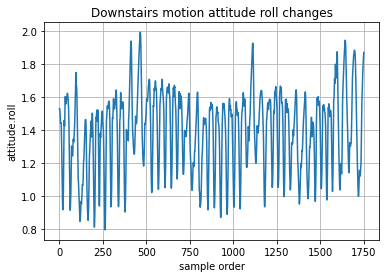

In [72]:
fig, ax = plt.subplots()
ax.plot(test_df_dws['attitude.roll'])
ax.set(xlabel='sample order', ylabel='attitude.roll',
       title='Downstairs motion attitude roll changes')
ax.grid()
plt.show()

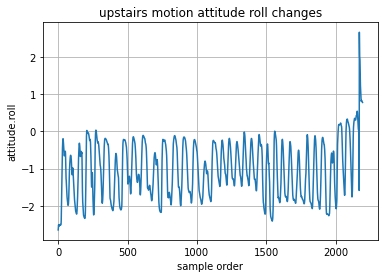

In [73]:
fig, ax = plt.subplots()
ax.plot(test_df_ups['attitude.roll'])
ax.set(xlabel='sample order', ylabel='attitude.roll',
       title='upstairs motion attitude roll changes')
ax.grid()
plt.show()

## CNN: Feature extraction, Train and Test ##

There are 24 data objects (people) performing motions. 6 different labels, each has different trials depending on time interval. 
We should get 24 * 15 = 360 such samples.


Long trials: those with number 1 to 9 with around 2 to 3 minutes duration.
Short trials: those with number 11 to 16 that are around 30 seconds to 1 minutes duration.

Sample rate is 50 Hz, this means a 2s window should have 100 samples.

In [74]:
#Feature extraction for NN model e.x. MLP
window = 600
feature_n = 6
attributes = ['attitude.roll', 'attitude.pitch', 'attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
data_all_x_list = []
data_all_y_list = []
for j in folders:
    csv_list = glob(j + '/*')
    label = j.split('/')[-1].split('_')[0]
    for i in csv_list:
        df = pd.read_csv(
            i,
            usecols = ['attitude.roll','attitude.pitch',
                       'attitude.yaw','userAcceleration.x',
                       'userAcceleration.y','userAcceleration.z']
         )
        win_count = int(df.shape[0] / (window / 2)) - 1
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)

        length = len(df)
        for c in range(win_count):
            start_idx = int(c * (window / 2))
            end_idx = start_idx + window
            temp_list = []
            for k in range(feature_n):
                means = df[start_idx:end_idx][attributes[k]].mean()
                stds = df[start_idx:end_idx][attributes[k]].mean()
                mins = df[start_idx:end_idx][attributes[k]].min()
                maxs = df[start_idx:end_idx][attributes[k]].max()
                mads = df[start_idx:end_idx][attributes[k]].mad()
                temp_list.append(means)
                temp_list.append(stds)
                temp_list.append(mins)
                temp_list.append(maxs)
                temp_list.append(mads)
            data_x[c] = temp_list
            data_y[c] = activity_codes[label]

        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(4174, 30)
(4174,)


## CNN 1. Feature Extraction + K-fold, Train & Test ##

In [75]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [76]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
assert(len(train_x) == len(train_y))
assert(len(test_x) == len(test_y))
print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(3339, 30) (835, 30)
(3339,) (835,)


In [77]:
kfold = KFold(n_splits=5, shuffle=True)

In [78]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [79]:
num_classes = 6
num_features = 30
batch_size = 32
acc_list = {}
f1_list = {}
train_acc_list = {}
fold_no = 1
epochs = 15
best_id = 1
best_acc = 0

for train, test in tqdm(kfold.split(train_x, train_y)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = (30,1)),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(input_shape = (30,1)),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    _train_x = train_x[train]
    _train_y = train_y[train]
    _val_x = train_x[test]
    _val_y = train_y[test]
    length_train = _train_x.shape[0]
    length_val = _val_x.shape[0]
    _train_x = tf.convert_to_tensor(_train_x, dtype=tf.float32)
    _train_x = tf.reshape(_train_x, (length_train, num_features, 1))
    _val_x = tf.convert_to_tensor(_val_x, dtype=tf.float32)
    _val_x = tf.reshape(_val_x, (length_val, num_features, 1))
    _train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(_train_y,  num_classes=6), dtype=tf.float32)
    _val_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(_val_y,  num_classes=6), dtype=tf.float32)
#     _train_dataset = tf.data.Dataset.from_tensor_slices((_train_x, _train_y))
#     _val_dataset = tf.data.Dataset.from_tensor_slices((_val_x, _val_y))
    history = model.fit(
        _train_x,
        _train_y,
        epochs=epochs
    )
    train_acc = history.history['accuracy']
    print(f"===Highest training accuracy: {max(train_acc)}===")
#     loss, accuracy, f1_score, precision, recall = model.evaluate(_val_x, _val_y_1, verbose=0)
#     print(f"===loss:{loss}, accuracy:{accuracy}, precision:{precision}, recall:{recall}, f1_score:{f1_score}")
    y_pred = model.predict(_val_x, verbose=0)
#     print(y_pred)
    y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
    f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
    acc_metric = tf.keras.metrics.Accuracy()
    #acc_metric.update_state(train_y[test], y_pred_1)
    acc_metric.update_state(_val_y, y_pred_1)
    acc = acc_metric.result().numpy()
    # print(acc)
    #y_pred_1 = y_pred_1.astype(np.float32)
    #f1_metric.update_state(train_y_1, y_pred)
    f1_metric.update_state(_val_y_1, y_pred)
    f1_macro = f1_metric.result().numpy()
    if acc > best_acc:
        best_acc = acc
        best_id = fold_no
    # print(f1_macro)
    print(f"===Validation accuracy for fold {fold_no}: {acc}; f1_macro is {f1_macro}===")
    acc_list[fold_no] = acc
    train_acc_list[fold_no] = train_acc
    f1_list[fold_no] = f1_macro
    model.save(os.path.join(save_path, f"cnn_{fold_no}.h5"))
    fold_no += 1

0it [00:00, ?it/s]

Epoch 1/15
84/84 [==============================] - 1s 2ms/step - loss: 1.4453 - accuracy: 0.4227
Epoch 2/15
84/84 [==============================] - 0s 2ms/step - loss: 0.7554 - accuracy: 0.7196
Epoch 3/15
84/84 [==============================] - 0s 2ms/step - loss: 0.5679 - accuracy: 0.7888
Epoch 4/15
84/84 [==============================] - 0s 3ms/step - loss: 0.4797 - accuracy: 0.8121
Epoch 5/15
84/84 [==============================] - 0s 3ms/step - loss: 0.4218 - accuracy: 0.8375
Epoch 6/15
84/84 [==============================] - 0s 3ms/step - loss: 0.3928 - accuracy: 0.8469
Epoch 7/15
84/84 [==============================] - 0s 3ms/step - loss: 0.3702 - accuracy: 0.8566
Epoch 8/15
84/84 [==============================] - 0s 3ms/step - loss: 0.3452 - accuracy: 0.8663
Epoch 9/15
84/84 [==============================] - 0s 2ms/step - loss: 0.3145 - accuracy: 0.8723
Epoch 10/15
84/84 [==============================] - 0s 2ms/step - loss: 0.2980 - accuracy: 0.8847
Epoch 11/15
84/84 [

In [80]:
length_test= test_x.shape[0]
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
test_x = tf.reshape(test_x, (length_test, num_features, 1))
test_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=6), dtype=tf.float32)
best_model = tf.keras.models.load_model(os.path.join(save_path, f"cnn_{best_id}.h5"))
y_pred = best_model.predict(test_x, verbose=0)
#     print(y_pred)
y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
acc_metric = tf.keras.metrics.Accuracy()
#acc_metric.update_state(train_y[test], y_pred_1)
acc_metric.update_state(test_y, y_pred_1)
acc = acc_metric.result().numpy()
# print(acc)
#y_pred_1 = y_pred_1.astype(np.float32)
#f1_metric.update_state(train_y_1, y_pred)
f1_metric.update_state(test_y_1, y_pred)
f1_macro = f1_metric.result().numpy()
print(f"test accuracy is {acc}")
print(f"test f1 macro is {f1_macro}")

test accuracy is 0.940119743347168
test f1 macro is 0.899529755115509


In [81]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

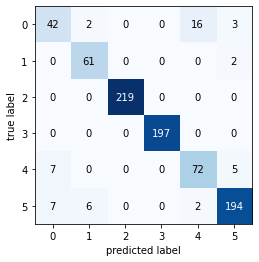

In [82]:
cm = confusion_matrix(y_target=test_y, 
                      y_predicted=y_pred_1, 
                      binary=False)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [83]:
_test_sample = test_df_dws[0:window]
temp_list = []
for k in range(feature_n):
    means = _test_sample[attributes[k]].mean()
    stds = _test_sample[attributes[k]].mean()
    mins = _test_sample[attributes[k]].min()
    maxs = _test_sample[attributes[k]].max()
    mads = _test_sample[attributes[k]].mad()
    temp_list.append(means)
    temp_list.append(stds)
    temp_list.append(mins)
    temp_list.append(maxs)
    temp_list.append(mads)
sample = np.asarray(temp_list).astype('float32').reshape((-1,1))
sample = tf.reshape(sample, (1, num_features, 1))
pred = best_model.predict(sample, verbose=0)
pred = np.argmax(pred, axis = 1)
print(f"This sample is a downstair motion, it is predicted to :{activity_decodes[pred[0]]}")

This sample is a downstair motion, it is predicted to :dws


## With out K-fold or Feature extraction, use validation set only ##
Update: We are testing this method with W9 data

# Week 9 Real Dataset #

## load real dataset ##
Dont be sad if it does not fit, at least it is real
This dataset is for w9, contains mermaid : 0, jamesbond: 1, dab:2

In [126]:
data_folder_path = os.path.join(os.getcwd(), 'w9_real_data')
data_folder_path_2 = os.path.join(os.getcwd(), 'w9_real_data_2')
data_folder_path_3 = os.path.join(os.getcwd(), 'w9_real_data_3')
data_folder_path_4 = os.path.join(os.getcwd(), 'w9_real_data_4')
folders = glob(os.path.join(data_folder_path,'*.csv'))
folders_2 = glob(os.path.join(data_folder_path_2,'*.csv'))
folders_3 = glob(os.path.join(data_folder_path_3,'*.csv'))
folders_4 = glob(os.path.join(data_folder_path_4,'*.csv'))
df_all_list = []
activity_codes = {'mermaid':0,'jamesbond':1,'dab':2}
activity_decodes = {0:'mermaid',1:'jamesbond',2:'dab'}
#usr_cols = ['attitude.roll','attitude.pitch','attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
activity_types = list(activity_codes.keys())
print(folders)

['/Users/apple/Desktop/CG4002_Capstone/ML/w9_real_data/dab.csv', '/Users/apple/Desktop/CG4002_Capstone/ML/w9_real_data/jamesbond.csv', '/Users/apple/Desktop/CG4002_Capstone/ML/w9_real_data/mermaid.csv']


###  study data set ###

(79, 6)


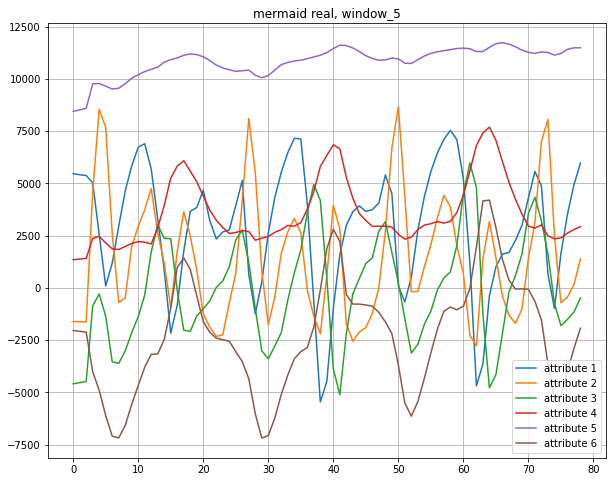

(107, 8)


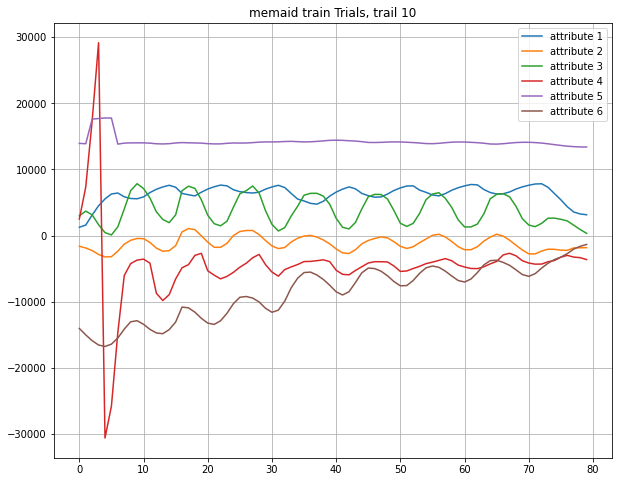

(150, 8)


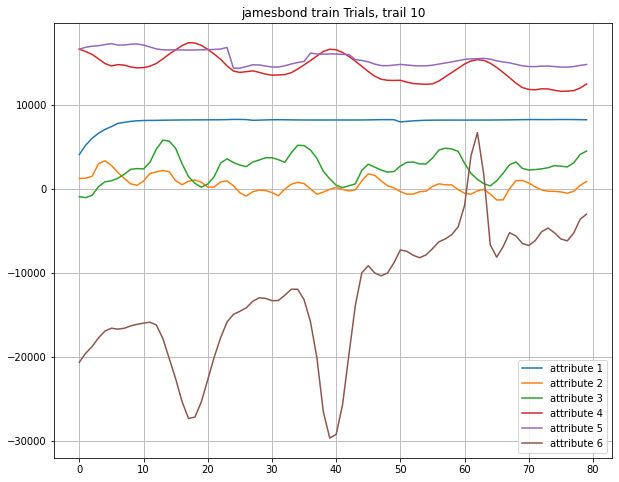

In [15]:
mermaid = np.array([[7472, -2897, -8946,   341,  4557,  -148],
 [ 7396, -2898, -8913,   345,  4668,  -177],
 [ 6927, -2743, -8661,  386,  5330,  -346],
 [ 6785, -2683, -8546,   408,  5544,  -403],
 [ 6690, -2668, -8513,   424,  5652,  -438],
 [ 6631, -2670, -8461 ,  435,  5758,  -473],
 [ 6539, -2647, -8420,   444, 5864,  -504],
 [ 6394, -2637, -8340,   472,  6073,  -576],
 [ 6309, -2611, -8303,   484,  6177,  -609],
 [ 6240, -2574, -8254,   496,  6281,  -642],
 [ 6180, -2561, -8204,   513,  6385,  -680],
 [ 6113, -2542, -8158,   529,  6488,  -717],
 [ 5990, -2503, -8050,   564,  6691,  -792],
 [ 5920, -2477, -7991,   581,  6792,  -829],
 [ 5860, -2472, -7939,   601,  6892,  -868],
 [ 5737, -2439, -7824,   639,  7090,  -943],
 [ 5673, -2421, -7773,   658,  7189,  -982],
 [ 5610, -2396, -7728,   679,  7286, -1022],
 [ 5554, -2381, -7665,   700,  7384, -1063],
 [ 5493, -2365, -7602,  721,  7480, -1103],
 [ 5444, -2333, -7548,   742,  7576, -1142],
 [ 5315, -2328, -7446,   794,  7765, -1232],
 [ 5266, -2305, -7378,   825,  7858, -1275],
 [ 5203, -2313, -7322,   848,  7950, -1319],
 [ 5157, -2268, -7263,   877,  8042, -1359],
 [ 6106,    76, -1359,  2739, 10044, -3063],
 [ 6340,  1263,  2127,  2805,  9949, -2709],
 [ 6362,  1569,  3506,  2927,  9968, -2714],
 [ 6119,  1777,  3898,  3017, 10090, -2824],
 [ 6401,   991,  2408,  3231, 10275, -3128],
 [ 7114,  -458,   332,  3394, 10453, -3510],
 [ 7640, -1943, -1679,  3267, 10582, -3802],
 [ 8038, -2587, -3006,  3067, 10650, -3880],
 [ 7726, -1464, -1348,  3132, 10628, -3039],
 [ 7316,   -30,  1428,  3114, 10534, -2511],
 [ 7161,  1250,  3955,  3095, 10467, -2242],
 [ 6788,  1967,  4933,  3320, 10493, -2333],
 [ 6677,  1553,  4242,  3564, 10610, -2561],
 [ 7607,  -939,   423,  3841, 10954, -3153],
 [ 7960, -2283, -1575,  3601, 11067, -3307],
 [ 8235, -2557, -1998,  3550, 11109, -3274],
 [ 8316,-2129, -1723,  3457, 11088, -2904],
 [ 7860, -1074,  -416,  3466, 11021, -2405],
 [ 6992,  1662,  3671,  3367, 10862, -1749],
 [ 6472,  1942,  4102,  3757, 10981, -2076],
 [ 6789,  1107,  3022,  4075, 11143, -2385],
 [ 7326,  -330,  1498,  4280, 11304, -2726],
 [ 7712, -1873,  -543,  4224, 11450, -2978],
 [ 8005, -2599, -1739,  4117, 11534, -3065],
 [ 8245, -2415, -1798,  4055, 11520, -2816],
[ 7352.,  -555.,  1004.,  3866., 11338., -1810.],
 [ 7081.,  1024.,  3160.,  3769., 11255., -1416.],
 [ 6554.,  2008.,  4889.,  3890., 11220., -1378.],
 [ 6259.,  1950.,  4808.,  4099., 11294., -1610.],
 [ 6684.,  1293.,  3474.,  4368., 11455., -1922.],
 [ 7222.,   144.,  2420.,  4813., 11623., -2280.],
 [ 7892., -2204.,  -170.,  4994., 11893., -2747.],
 [ 8106., -2866., -1557.,  4890., 11964., -2821.],
 [ 8264., -3233., -2364.,  4565., 11962., -2748.],
 [ 7481., -2748., -2231.,  4323., 11906., -2239.],
 [ 5861.,  -169.,  -377.,  4066., 11769., -1367.],
 [ 4836.,   810.,   432.,  3860., 11598.,  -610.],
 [ 3744.,   735.,  -543.,  3721., 11405.,  1364.],
 [ 3887.,   149., -1581.,  3742., 11374.,  1812.],
 [ 3848., -1046., -2314.,  4041., 11403.,  1792.],
 [ 3672., -2213., -3171.,  3963., 11484.,  1766.],
 [ 3554., -3424., -3834.,  3888., 11572.,  1628.],
 [ 3407., -4591., -4990.,  3882., 11729.,  1505.],
 [ 3288., -4872., -5130.,  4080., 11795.,  1371.],
 [ 3316., -5190., -5258.,  4155., 11862.,  1186.],
 [ 3259., -5481., -5693.,  4229., 12028.,   944.],
 [ 3232., -5518., -5711.,  4361., 12099.,   824.],
 [ 3254., -5545., -5823.,  4463., 12174.,   670.],
 [ 3229., -5588., -5828.,  4526., 12254.,   540.],
 [ 3212., -5591., -5835.,  4596., 12331.,   404.],
 [ 3203., -5594., -5850.,  4695., 12406.,   252.],
 [ 3185., -5617., -5830.,  4774., 12482.,    95.],
 [ 3144., -5552., -5746.,  4914., 12628.,  -223.],
 [ 3127., -5532., -5700.,  4998., 12698.,  -394.],
 [ 3101., -5479., -5619.,  5072., 12766.,  -569.],
                   ]
)
window_1 = pd.read_csv('prediction_dfs/prediction_df_0_80.csv')
window_2 = pd.read_csv('prediction_dfs/prediction_df_40_120.csv')
window_3 = pd.read_csv('prediction_dfs/prediction_df_80_160.csv')
window_4 = pd.read_csv('prediction_dfs/prediction_df_120_200.csv')
window_5 = pd.read_csv('prediction_dfs/prediction_df_160_240.csv')

data = window_1
print(data.shape)
fig, ax = plt.subplots(figsize = [10,8])
for i in range(0,6):
    x = [j for j in range(len(data))]
    temp = data.iloc[:,i].copy()
    ax.plot(x, temp, label = f"attribute {str(i+1)}")
#     temp = temp.ewm(com = 2).mean()
#     ax.plot(x, temp, label = f"after EMA {str(i + 1)}")

plt.title(f"mermaid real, window_5")
plt.legend()
ax.grid()
plt.show()

test_data = pd.read_csv(os.path.join(data_folder_path_3, 'mermaid.csv'), index_col = False)
test_data = test_data[test_data['0'] == 10]
print(test_data.shape)
test_data = test_data[0:80]
fig, ax = plt.subplots(figsize = [10,8])
for i in range(1,7):
    x = [i for i in range(test_data.shape[0])]
    ax.plot(x, test_data[str(i)], label = f"attribute {str(i)}")
#     temp = temp.ewm(com = 2).mean()
#     ax.plot(x, temp['4'], label = f"trial after EMA {str(i)}")

plt.title('memaid train Trials, trail 10')
plt.legend()
ax.grid()
plt.show()

test_data = pd.read_csv(os.path.join(data_folder_path_3, 'jamesbond.csv'), index_col = False)
test_data = test_data[test_data['0'] == 10]
print(test_data.shape)
test_data = test_data[0:80]
fig, ax = plt.subplots(figsize = [10,8])
for i in range(1,7):
    x = [i for i in range(test_data.shape[0])]
    ax.plot(x, test_data[str(i)], label = f"attribute {str(i)}")
#     temp = temp.ewm(com = 2).mean()
#     ax.plot(x, temp['4'], label = f"trial after EMA {str(i)}")

plt.title('jamesbond train Trials, trail 10')
plt.legend()
ax.grid()
plt.show()

(403, 8)


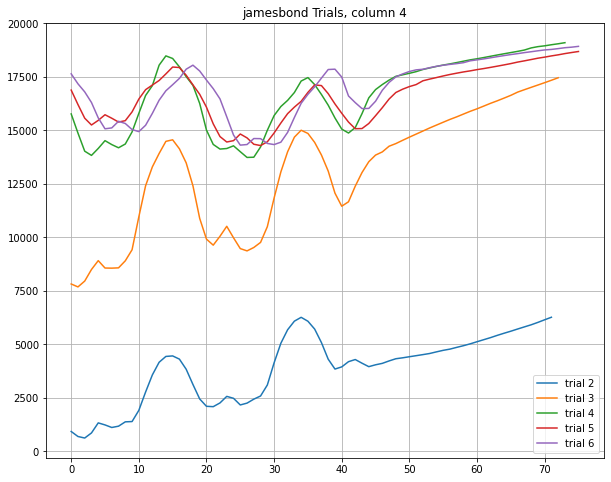

In [6]:
test_data = pd.read_csv(os.path.join(data_folder_path, 'jamesbond.csv'), index_col = False)
print(test_data.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(2,7):
    temp = test_data[test_data['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['4'], label = f"trial {str(i)}")
#     temp = temp.ewm(com = 2).mean()
#     ax.plot(x, temp['4'], label = f"trial after EMA {str(i)}")

plt.title('jamesbond Trials, column 4')
plt.legend()
ax.grid()
plt.show()

(3192, 8)


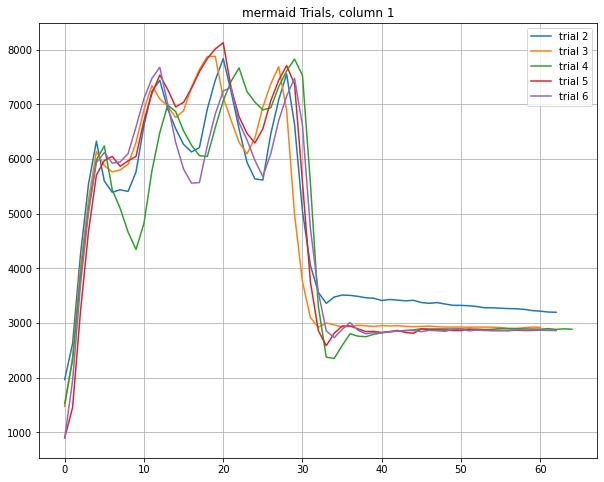

In [26]:
test_data_2 = pd.read_csv(os.path.join(data_folder_path_2, 'mermaid.csv'), index_col = False)
print(test_data_2.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(2,7):
    temp = test_data_2[test_data_2['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['1'], label = f"trial {str(i)}")

plt.title('mermaid Trials, column 1')
plt.legend()
ax.grid()
plt.show()

(6911, 8)


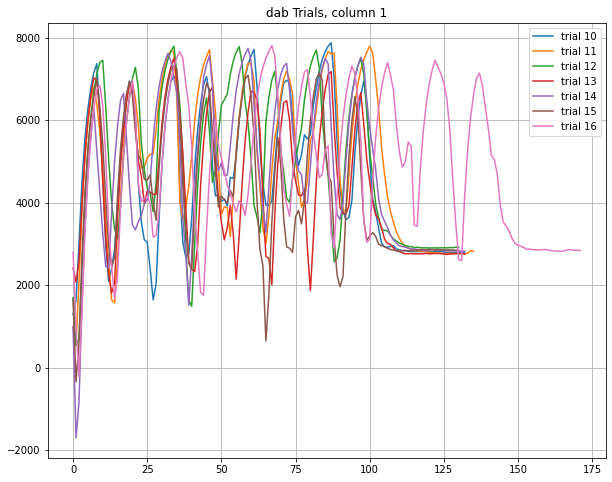

In [10]:
test_data_3 = pd.read_csv(os.path.join(data_folder_path_3, 'dab.csv'), index_col = False)
print(test_data_3.shape)

fig, ax = plt.subplots(figsize = [10,8])
for i in range(10,17):
    temp = test_data_3[test_data_3['0'] == i]
    x = [i for i in range(temp.shape[0])]
    ax.plot(x, temp['1'], label = f"trial {str(i)}")

plt.title('dab Trials, column 1')
plt.legend()
ax.grid()
plt.show()

### Load ###

In [127]:
#hyper parameters
# window size is 3 s, sample rate 20 Hz
# Sliding window
window = 80
frequency = 20
cut_size_cand = 20
distinct_in_overlap = 20
overlap = int(((window - distinct_in_overlap) / window) * 100)
print(overlap)
ema = True
com = 2
# We need to skip the first trial
n_trials = 6
# We skip tial if it is less than the window length. How many we have?
skip_c = 0
# from col 1 to 6: Accelerometer x, y, z, yall, pitch, roll
usr_cols = ['1','2','3','4','5','6']
drop_cols = ['0', 'Unnamed: 0']
feature_n = 6

75


In [128]:
data_all_x_list = []
data_all_y_list = []
for filename in folders:
    label_name = filename.split('/')[-1].split('.')[0]
    print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path, filename), index_col = False)
    #print(f"motion_df's shape is : {motion_df.shape}")
    for i in range(2, 1 + n_trials):
        df = motion_df[motion_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(f"initial shape {df.shape}")
        if length < window:
            skip_c += 1
            continue
        # We cut the ending part, if we don't have enough, we dont cut
        cut_size = min(cut_size_cand, length - window)
        length -= cut_size
        df = df[0:length]
        #print(f"shape after cut tail: {df.shape}")    
        # We apply EMA filter here
        if ema:
            df = df.ewm(com = com).mean()
        #sliding window
        win_count = 1
        win_count += int((length - window)/ distinct_in_overlap)
        #print(win_count)
        data_x = np.zeros((win_count, window, df.shape[1]))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * distinct_in_overlap)
            end_idx = start_idx + window
            #print(df[start_idx:end_idx].shape)
            data_x[c,:,:] = df[start_idx:end_idx].values
            data_y[:] = activity_codes[label_name]
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y) 

dab
jamesbond
mermaid


In [129]:
#Second part of the data, some are interrupted at the middle
# For dab
dab_2 = os.path.join(data_folder_path_2, 'dab.csv')
label_name = dab_2.split('/')[-1].split('.')[0]
print(label_name)
dab_df = pd.read_csv(dab_2, index_col = False)
#print(list(dab_df.columns))
dab_df_1 = dab_df[dab_df['Unnamed: 0'] <= 1353]
dab_df_2 = dab_df[dab_df['Unnamed: 0'] > 1353]

for i in range(2, 20):
    df = dab_df_1[dab_df_1['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(cut_size_cand, length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, window, df.shape[1]))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        data_x[c,:,:] = df[start_idx:end_idx].values
        data_y[:] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)
    
for i in range(2, 51):
    df = dab_df_2[dab_df_2['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(cut_size_cand, length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, window, df.shape[1]))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        data_x[c,:,:] = df[start_idx:end_idx].values
        data_y[:] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)

# For jamesbond
jamesbond_2 = os.path.join(data_folder_path_2, 'jamesbond.csv')
label_name = jamesbond_2.split('/')[-1].split('.')[0]
print(label_name)
jamesbond_df = pd.read_csv(jamesbond_2, index_col = False)
#print(list(jamesbond_df.columns))
jamesbond_df_1 = jamesbond_df[jamesbond_df['Unnamed: 0'] <= 3289]
jamesbond_df_2 = jamesbond_df[jamesbond_df['Unnamed: 0'] > 3289]
for i in range(2, 46):
    df = jamesbond_df_1[jamesbond_df_1['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(cut_size_cand, length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, window, df.shape[1]))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        data_x[c,:,:] = df[start_idx:end_idx].values
        data_y[:] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)
    
for i in range(2, 8):
    df = jamesbond_df_2[jamesbond_df_2['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(cut_size_cand, length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, window, df.shape[1]))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        data_x[c,:,:] = df[start_idx:end_idx].values
        data_y[:] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)

# for mermaid
mermaid_2 = os.path.join(data_folder_path_2, 'mermaid.csv')
label_name = mermaid_2.split('/')[-1].split('.')[0]
print(label_name)
mermaid_df = pd.read_csv(mermaid_2, index_col = False)
#print(list(mermaid_df.columns))
for i in range(2, 49):
    df = mermaid_df[mermaid_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(cut_size_cand, length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, window, df.shape[1]))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        data_x[c,:,:] = df[start_idx:end_idx].values
        data_y[:] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)

dab
jamesbond
mermaid


In [130]:
#Part 3
n_trials = 51
for filename in folders_3:
    label_name = filename.split('/')[-1].split('.')[0]
    print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path_3, filename), index_col = False)
    #print(f"{label_name} df shape is : {motion_df.shape}")
    for i in range(2, 1 + n_trials):
        df = motion_df[motion_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(df.shape)
        if length < window:
            skip_c += 1
            continue
        # We cut the tail, if we don't have enough, we dont cut
        cut_size = min(cut_size_cand, length - window)
        length -= cut_size
        df = df[0:length]
        #print(f"shape after cut tail: {df.shape}")
        # We apply EMA filter here
        if ema:
            df = df.ewm(com = com).mean()
        #sliding window
        win_count = 1
        win_count += int((length - window)/ distinct_in_overlap)
        #print(f"we have {win_count} window for trail {i}")
        data_x = np.zeros((win_count, window, df.shape[1]))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * distinct_in_overlap)
            end_idx = start_idx + window
            data_x[c,:,:] = df[start_idx:end_idx].values
            data_y[:] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)

dab
jamesbond
mermaid


In [131]:
# Part 4
for filename in folders_4:
    label_name = filename.split('/')[-1].split('.')[0]
    if label_name == 'mermaid_2':
        label_name = 'mermaid'
    print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path_4, filename), index_col = False)
    #print(f"{label_name} df shape is : {motion_df.shape}")
    n_trials = motion_df['0'].max()
    print(n_trials)
    for i in range(2, 1 + n_trials):
        df = motion_df[motion_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(df.shape)
        if length < window:
            skip_c += 1
            continue
        # We cut the tail, if we don't have enough, we dont cut
        cut_size = min(cut_size_cand, length - window)
        length -= cut_size
        df = df[0:length]
        #print(f"shape after cut tail: {df.shape}")
        # We apply EMA filter here
        if ema:
            df = df.ewm(com = com).mean()
        #sliding window
        win_count = 1
        win_count += int((length - window)/ distinct_in_overlap)
        #print(f"we have {win_count} window for trail {i}")
        data_x = np.zeros((win_count, window, df.shape[1]))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * distinct_in_overlap)
            end_idx = start_idx + window
            data_x[c,:,:] = df[start_idx:end_idx].values
            data_y[:] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)

dab
51
jamesbond
51
mermaid
20
mermaid
35


In [132]:
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape) 
print(f"we skipped {skip_c} trials")

(835, 80, 6)
(835,)
we skipped 168 trials


In [133]:
count_mermaid = 0
count_jamesbond = 0
count_dab = 0
for i in data_all_y:
    if i == 0:
        count_mermaid += 1
    elif i == 1:
        count_jamesbond += 1
    elif i == 2:
        count_dab += 1
    else:
        print("you are not a member of the family")
print(f"mermaid: {count_mermaid}, jamesbond: {count_jamesbond}, dab: {count_dab}")

mermaid: 222, jamesbond: 312, dab: 301


## What about dirrectly train with CNN? ##

In [16]:
train_x_temp,test_x,train_y_temp,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x_temp,train_y_temp,test_size=0.1)
assert(len(train_x) == len(train_y))
print(len(train_x), len(test_x),len(val_x))

428 119 48


In [17]:
# Save test file to be test in ultra96 with tflite
print(test_x[20].shape)
_label = test_y[20]
print(_label)
with open('test_single_y.txt', 'w') as f:
    f.write('%d' % _label)
pd.DataFrame(test_x[20]).to_csv("test_single_x.csv", index = False)
#pd.DataFrame(test_y[100]).to_csv("test_single_y.csv")

(60, 6)
2


In [18]:
num_classes = 3
input_shape = (60, 6)
# val_y = np.asarray(val_y).astype('float32').reshape((-1,1))
# train_y = np.asarray(train_y).astype('float32').reshape((-1,1))
# test_y = np.asarray(test_y).astype('float32').reshape((-1,1))
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
val_x = tf.convert_to_tensor(val_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(train_y,  num_classes=num_classes), dtype=tf.float32)
test_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=num_classes), dtype=tf.float32)
val_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(val_y,  num_classes=num_classes), dtype=tf.float32)

2021-10-12 08:48:30.599611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [20]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [21]:
for i,j in val_dataset.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(32, 60, 6)
(32, 3)


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(padding='same'),
    tf.keras.layers.Flatten(input_shape = input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 58, 32)            608       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/50
14/14 [==============================] - 0s 10ms/step - loss: 1.0380 - accuracy: 0.4065 - val_loss: 0.9994 - val_accuracy: 0.5000
Epoch 2/50
14/14 [==============================] - 0s 8ms/step - loss: 1.0378 - accuracy: 0.4673 - val_loss: 0.9456 - val_accuracy: 0.6042
Epoch 3/50
14/14 [==============================] - 0s 9ms/step - loss: 0.9821 - accuracy: 0.4650 - val_loss: 0.9530 - val_accuracy: 0.6458
Epoch 4/50
14/14 [==============================] - 0s 5ms/step - loss: 0.9395 - accuracy: 0.5467 - val_loss: 0.8635 - val_accuracy: 0.6875
Epoch 5/50
14/14 [==============================] - 0s 6ms/step - loss: 0.9204 - accuracy: 0.5350 - val_loss: 0.9222 - val_accuracy: 0.5208
Epoch 6/50
14/14 [==============================] - 0s 7ms/step - loss: 0.9960 - accuracy: 0.4650 - val_loss: 0.8922 - val_accuracy: 0.6042
Epoch 7/50
14/14 [==============================] - 0s 6ms/step - loss: 0.9104 - accuracy: 0.5304 - val_loss: 0.7846 - val_accuracy: 0.6458
Epoch 8/50
14/14 [=

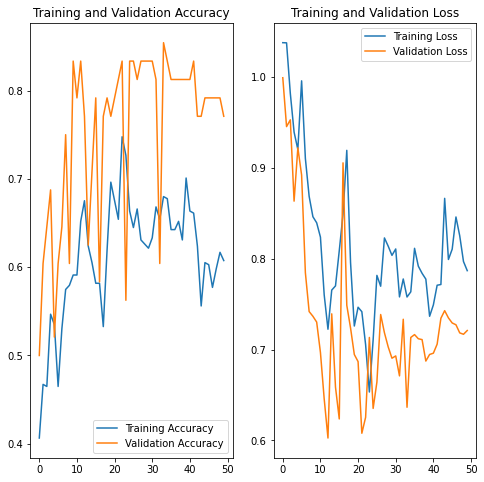

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
print(f"best training accruacy:{max(history.history['accuracy'])}")
print(f"best validation accruacy:{max(history.history['val_accuracy'])}")

best training accruacy:0.7476635575294495
best validation accruacy:0.8541666865348816


In [37]:
# model.save('boing_cnn.h5')

In [38]:
model.evaluate(test_dataset,batch_size = BATCH_SIZE)

4/4 [==============================] - 0s 8ms/step - loss: 0.7226 - accuracy: 0.7311


[0.7225801944732666, 0.7310924530029297]

## What about K-fold cross validation? ##

In [134]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.15)
assert(len(train_x) == len(train_y))
assert(len(test_x) == len(test_y))
print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(709, 80, 6) (126, 80, 6)
(709,) (126,)


In [135]:
# Save test file to be test in ultra96 with tflite
print(test_x[20].shape)
_label = test_y[20]
print(_label)
with open(f"test_single_y_{window}.txt", 'w') as f:
    f.write('%d' % _label)
pd.DataFrame(test_x[20]).to_csv(f"test_single_x_{window}.csv", index = False)
#pd.DataFrame(test_y[100]).to_csv("test_single_y.csv")

(80, 6)
2


In [136]:
kfold = KFold(n_splits=5, shuffle=True)

In [137]:
num_classes = 3
num_features = 6
batch_size = 16
acc_list = {}
f1_list = {}
train_acc_list = {}
fold_no = 1
epochs = 20
best_id = 1
best_acc = 0
input_shape = (window,6)
save_path = os.path.join(os.getcwd(), 'temp_models')

for train, test in tqdm(kfold.split(train_x, train_y)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(input_shape = input_shape),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    _train_x = train_x[train]
    _train_y = train_y[train]
    _val_x = train_x[test]
    _val_y = train_y[test]
#     print(_train_x.shape)
#     print(_train_y.shape)
#     print(_val_x.shape)
#     print(_val_y.shape)
    length_train = _train_x.shape[0]
    length_val = _val_x.shape[0]
    _train_x = tf.convert_to_tensor(_train_x, dtype=tf.float32)
    _val_x = tf.convert_to_tensor(_val_x, dtype=tf.float32)
    #If feature extraction is used, then the input is 1d array, we need re format for cnn
#     _train_x = tf.reshape(_train_x, (length_train, num_features, 1))
#     _val_x = tf.reshape(_val_x, (length_val, num_features, 1))
    _train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(_train_y,  num_classes=num_classes), dtype=tf.float32)
    _val_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(_val_y,  num_classes= num_classes), dtype=tf.float32)
#     _train_dataset = tf.data.Dataset.from_tensor_slices((_train_x, _train_y))
#     _val_dataset = tf.data.Dataset.from_tensor_slices((_val_x, _val_y))
    history = model.fit(
        _train_x,
        _train_y,
        epochs=epochs
    )
    train_acc = history.history['accuracy']
    print(f"===Highest training accuracy: {max(train_acc)}===")
#     loss, accuracy, f1_score, precision, recall = model.evaluate(_val_x, _val_y_1, verbose=0)
#     print(f"===loss:{loss}, accuracy:{accuracy}, precision:{precision}, recall:{recall}, f1_score:{f1_score}")
    y_pred = model.predict(_val_x, verbose=0)
#     print(y_pred)
    y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
    f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
    acc_metric = tf.keras.metrics.Accuracy()
    #acc_metric.update_state(train_y[test], y_pred_1)
    acc_metric.update_state(_val_y, y_pred_1)
    acc = acc_metric.result().numpy()
    # print(acc)
    #y_pred_1 = y_pred_1.astype(np.float32)
    #f1_metric.update_state(train_y_1, y_pred)
    f1_metric.update_state(_val_y_1, y_pred)
    f1_macro = f1_metric.result().numpy()
    if acc > best_acc:
        best_acc = acc
        best_id = fold_no
    # print(f1_macro)
    print(f"===Validation accuracy for fold {fold_no}: {acc}; f1_macro is {f1_macro}===")
    acc_list[fold_no] = acc
    train_acc_list[fold_no] = train_acc
    f1_list[fold_no] = f1_macro
    model.save(os.path.join(save_path, f"cnn_kfold_fold{fold_no}.h5"))
    fold_no += 1

0it [00:00, ?it/s]

Epoch 1/20
18/18 [==============================] - 1s 6ms/step - loss: 1.2075 - accuracy: 0.3474
Epoch 2/20
18/18 [==============================] - 0s 8ms/step - loss: 1.1110 - accuracy: 0.4004
Epoch 3/20
18/18 [==============================] - 0s 5ms/step - loss: 1.0859 - accuracy: 0.4568
Epoch 4/20
18/18 [==============================] - 0s 6ms/step - loss: 1.1484 - accuracy: 0.3633
Epoch 5/20
18/18 [==============================] - 0s 5ms/step - loss: 1.1161 - accuracy: 0.3951
Epoch 6/20
18/18 [==============================] - 0s 6ms/step - loss: 1.0605 - accuracy: 0.4444
Epoch 7/20
18/18 [==============================] - 0s 6ms/step - loss: 1.0339 - accuracy: 0.4409
Epoch 8/20
18/18 [==============================] - 0s 6ms/step - loss: 1.0259 - accuracy: 0.4515
Epoch 9/20
18/18 [==============================] - 0s 6ms/step - loss: 0.9812 - accuracy: 0.4727
Epoch 10/20
18/18 [==============================] - 0s 6ms/step - loss: 1.0034 - accuracy: 0.4656
Epoch 11/20
18/18 [

In [138]:
length_test= test_x.shape[0]
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
#Again, we conly need below line if feature extraction is used
#test_x = tf.reshape(test_x, (length_test, num_features, 1))
test_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=num_classes), dtype=tf.float32)
best_model = tf.keras.models.load_model(os.path.join(save_path, f"cnn_kfold_fold{best_id}.h5"))
y_pred = best_model.predict(test_x, verbose=0)
#     print(y_pred)
y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
acc_metric = tf.keras.metrics.Accuracy()
#acc_metric.update_state(train_y[test], y_pred_1)
acc_metric.update_state(test_y, y_pred_1)
acc = acc_metric.result().numpy()
# print(acc)
#y_pred_1 = y_pred_1.astype(np.float32)
#f1_metric.update_state(train_y_1, y_pred)
f1_metric.update_state(test_y_1, y_pred)
f1_macro = f1_metric.result().numpy()
print(f"test accuracy is {acc}")
print(f"test f1 macro is {f1_macro}")

test accuracy is 0.817460298538208
test f1 macro is 0.8210165500640869


In [139]:
print(best_id)

4


In [140]:
best_model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 78, 32)            608       
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 39, 32)            0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 37, 32)            3104      
_________________________________________________________________
max_pooling1d_115 (MaxPoolin (None, 18, 32)            0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 16, 32)            3104      
_________________________________________________________________
max_pooling1d_116 (MaxPoolin (None, 8, 32)             0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 256)             

## What about feature extraction? ##

### load dataset using feature extraction ###

In [88]:
data_all_x_list = []
data_all_y_list = []
for filename in folders:
    label_name = filename.split('/')[-1].split('.')[0]
    print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path, filename), index_col = False)
    #print(f"motion_df's shape is : {motion_df.shape}")
    for i in range(2, 1 + n_trials):
        df = motion_df[motion_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(df.shape)
        if length < window:
            skip_c += 1
            continue
        # We cut the ending part, if we don't have enough, we dont cut
        cut_size = min(int(frequency / 2), length - window)
        length -= cut_size
        df = df[0:length]
        # We apply EMA filter here
        if ema:
            df = df.ewm(com = com).mean()
        #sliding window
        win_count = 1
        win_count += int((length - window)/ distinct_in_overlap)
        #print(win_count)
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * distinct_in_overlap)
            end_idx = start_idx + window
            temp_list = []
            for k in range(1, 1 + feature_n):
                means = df[start_idx:end_idx][str(k)].mean()
                stds = df[start_idx:end_idx][str(k)].mean()
                mins = df[start_idx:end_idx][str(k)].min()
                maxs = df[start_idx:end_idx][str(k)].max()
                mads = df[start_idx:end_idx][str(k)].mad()
                temp_list.append(means)
                temp_list.append(stds)
                temp_list.append(mins)
                temp_list.append(maxs)
                temp_list.append(mads)
            data_x[c] = temp_list
            data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y) 

#Second part of the data, some are interrupted at the middle
# For dab
dab_2 = os.path.join(data_folder_path_2, 'dab.csv')
label_name = dab_2.split('/')[-1].split('.')[0]
print(label_name)
dab_df = pd.read_csv(dab_2, index_col = False)
#print(list(dab_df.columns))
dab_df_1 = dab_df[dab_df['Unnamed: 0'] <= 1353]
dab_df_2 = dab_df[dab_df['Unnamed: 0'] > 1353]

for i in range(2, 20):
    df = dab_df_1[dab_df_1['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)
    
for i in range(2, 51):
    df = dab_df_2[dab_df_2['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)

# For jamesbond
jamesbond_2 = os.path.join(data_folder_path_2, 'jamesbond.csv')
label_name = jamesbond_2.split('/')[-1].split('.')[0]
print(label_name)
jamesbond_df = pd.read_csv(jamesbond_2, index_col = False)
#print(list(jamesbond_df.columns))
jamesbond_df_1 = jamesbond_df[jamesbond_df['Unnamed: 0'] <= 3289]
jamesbond_df_2 = jamesbond_df[jamesbond_df['Unnamed: 0'] > 3289]
for i in range(2, 46):
    df = jamesbond_df_1[jamesbond_df_1['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)
    
for i in range(2, 8):
    df = jamesbond_df_2[jamesbond_df_2['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)

# for mermaid
mermaid_2 = os.path.join(data_folder_path_2, 'mermaid.csv')
label_name = mermaid_2.split('/')[-1].split('.')[0]
print(label_name)
mermaid_df = pd.read_csv(mermaid_2, index_col = False)
#print(list(mermaid_df.columns))
for i in range(2, 49):
    df = mermaid_df[mermaid_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
    df.drop(columns = drop_cols, inplace = True)
    length = df.shape[0]
    if length < window:
        skip_c += 1
        continue
    #print(df.shape)
    # We cut the ending part, if we don't have enough, we dont cut
    cut_size = min(int(frequency / 2), length - window)
    length -= cut_size
    df = df[0:length]
    #print(f"shape after cut tail: {df.shape}")
    # We apply EMA filter here
    if ema:
        df = df.ewm(com = com).mean()
    #sliding window
    win_count = 1
    win_count += int((length - window)/ distinct_in_overlap)
    #print(win_count)
    data_x = np.zeros((win_count, df.shape[1] * 5))
    data_y = np.zeros(win_count)
    for c in range(win_count):
        start_idx = int(c * distinct_in_overlap)
        end_idx = start_idx + window
        temp_list = []
        for k in range(1, 1 + feature_n):
            means = df[start_idx:end_idx][str(k)].mean()
            stds = df[start_idx:end_idx][str(k)].mean()
            mins = df[start_idx:end_idx][str(k)].min()
            maxs = df[start_idx:end_idx][str(k)].max()
            mads = df[start_idx:end_idx][str(k)].mad()
            temp_list.append(means)
            temp_list.append(stds)
            temp_list.append(mins)
            temp_list.append(maxs)
            temp_list.append(mads)
        data_x[c] = temp_list
        data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
    data_all_x_list.append(data_x)
    data_all_y_list.append(data_y)

n_trials = 51
for filename in folders_3:
    label_name = filename.split('/')[-1].split('.')[0]
    print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path_3, filename), index_col = False)
    #print(f"{label_name} df shape is : {motion_df.shape}")
    for i in range(2, 1 + n_trials):
        df = motion_df[motion_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(df.shape)
        if length < window:
            skip_c += 1
            continue
        # We cut the tail, if we don't have enough, we dont cut
        cut_size = min(int(frequency / 2), length - window)
        length -= cut_size
        df = df[0:length]
        #print(f"shape after cut tail: {df.shape}")
        # We apply EMA filter here
        if ema:
            df = df.ewm(com = com).mean()
        #sliding window
        win_count = 1
        win_count += int((length - window)/ distinct_in_overlap)
        #print(f"we have {win_count} window for trail {i}")
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * distinct_in_overlap)
            end_idx = start_idx + window
            temp_list = []
            for k in range(1, 1 + feature_n):
                means = df[start_idx:end_idx][str(k)].mean()
                stds = df[start_idx:end_idx][str(k)].mean()
                mins = df[start_idx:end_idx][str(k)].min()
                maxs = df[start_idx:end_idx][str(k)].max()
                mads = df[start_idx:end_idx][str(k)].mad()
                temp_list.append(means)
                temp_list.append(stds)
                temp_list.append(mins)
                temp_list.append(maxs)
                temp_list.append(mads)
            data_x[c] = temp_list
            data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)

# Part 4
for filename in folders_4:
    label_name = filename.split('/')[-1].split('.')[0]
    if label_name == 'mermaid_2':
        label_name = 'mermaid'
    print(label_name)
    motion_df = pd.read_csv(os.path.join(data_folder_path_4, filename), index_col = False)
    #print(f"{label_name} df shape is : {motion_df.shape}")
    n_trials = motion_df['0'].max()
    print(n_trials)
    for i in range(2, 1 + n_trials):
        df = motion_df[motion_df['0'] == i].copy()
#         drop_columns = list(set(df.columns) - set(usr_cols))
        df.drop(columns = drop_cols, inplace = True)
        length = df.shape[0]
        #print(df.shape)
        if length < window:
            skip_c += 1
            continue
        # We cut the tail, if we don't have enough, we dont cut
        cut_size = min(int(frequency / 2), length - window)
        length -= cut_size
        df = df[0:length]
        #print(f"shape after cut tail: {df.shape}")
        # We apply EMA filter here
        if ema:
            df = df.ewm(com = com).mean()
        #sliding window
        win_count = 1
        win_count += int((length - window)/ distinct_in_overlap)
        #print(f"we have {win_count} window for trail {i}")
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)
        for c in range(win_count):
            start_idx = int(c * distinct_in_overlap)
            end_idx = start_idx + window
            temp_list = []
            for k in range(1, 1 + feature_n):
                means = df[start_idx:end_idx][str(k)].mean()
                stds = df[start_idx:end_idx][str(k)].mean()
                mins = df[start_idx:end_idx][str(k)].min()
                maxs = df[start_idx:end_idx][str(k)].max()
                mads = df[start_idx:end_idx][str(k)].mad()
                temp_list.append(means)
                temp_list.append(stds)
                temp_list.append(mins)
                temp_list.append(maxs)
                temp_list.append(mads)
            data_x[c] = temp_list
            data_y[c] = activity_codes[label_name]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)

dab
jamesbond
mermaid
dab
jamesbond
mermaid
dab
jamesbond
mermaid
dab
51
jamesbond
51
mermaid
20
mermaid
35


In [89]:
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(3481, 30)
(3481,)


In [90]:
count_mermaid = 0
count_jamesbond = 0
count_dab = 0
for i in data_all_y:
    if i == 0:
        count_mermaid += 1
    elif i == 1:
        count_jamesbond += 1
    elif i == 2:
        count_dab += 1
    else:
        print("you are not a member of the family")
print(f"mermaid: {count_mermaid}, jamesbond: {count_jamesbond}, dab: {count_dab}")

mermaid: 993, jamesbond: 1235, dab: 1253


### Train with K-fold since K-fold performs better ###

In [91]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
assert(len(train_x) == len(train_y))
assert(len(test_x) == len(test_y))
print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(2784, 30) (697, 30)
(2784,) (697,)


In [92]:
# Save test file to be test in ultra96 with tflite
print(test_x[20].shape)
_label = test_y[20]
print(_label)
with open('test_single_y.txt', 'w') as f:
    f.write('%d' % _label)
pd.DataFrame(test_x[20]).to_csv("test_single_x.csv", index = False)
#pd.DataFrame(test_y[100]).to_csv("test_single_y.csv")

(30,)
2


In [93]:
kfold = KFold(n_splits=5, shuffle=True)

In [94]:
num_classes = 3
num_features = 30
batch_size = 16
acc_list = {}
f1_list = {}
train_acc_list = {}
fold_no = 1
epochs = 20
best_id = 1
best_acc = 0
input_shape = (num_features, 1)
save_path = os.path.join(os.getcwd(), 'temp_models')

for train, test in tqdm(kfold.split(train_x, train_y)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = input_shape),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(input_shape = input_shape),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    _train_x = train_x[train]
    _train_y = train_y[train]
    _val_x = train_x[test]
    _val_y = train_y[test]
#     print(_train_x.shape)
#     print(_train_y.shape)
#     print(_val_x.shape)
#     print(_val_y.shape)
    length_train = _train_x.shape[0]
    length_val = _val_x.shape[0]
    _train_x = tf.convert_to_tensor(_train_x, dtype=tf.float32)
    _val_x = tf.convert_to_tensor(_val_x, dtype=tf.float32)
    #If feature extraction is used, then the input is 1d array, we need re format for cnn
    _train_x = tf.reshape(_train_x, (length_train, num_features, 1))
    _val_x = tf.reshape(_val_x, (length_val, num_features, 1))
    _train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(_train_y,  num_classes=num_classes), dtype=tf.float32)
    _val_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(_val_y,  num_classes= num_classes), dtype=tf.float32)
#     _train_dataset = tf.data.Dataset.from_tensor_slices((_train_x, _train_y))
#     _val_dataset = tf.data.Dataset.from_tensor_slices((_val_x, _val_y))
    history = model.fit(
        _train_x,
        _train_y,
        epochs=epochs
    )
    train_acc = history.history['accuracy']
    print(f"===Highest training accuracy: {max(train_acc)}===")
#     loss, accuracy, f1_score, precision, recall = model.evaluate(_val_x, _val_y_1, verbose=0)
#     print(f"===loss:{loss}, accuracy:{accuracy}, precision:{precision}, recall:{recall}, f1_score:{f1_score}")
    y_pred = model.predict(_val_x, verbose=0)
#     print(y_pred)
    y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
    f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
    acc_metric = tf.keras.metrics.Accuracy()
    #acc_metric.update_state(train_y[test], y_pred_1)
    acc_metric.update_state(_val_y, y_pred_1)
    acc = acc_metric.result().numpy()
    # print(acc)
    #y_pred_1 = y_pred_1.astype(np.float32)
    #f1_metric.update_state(train_y_1, y_pred)
    f1_metric.update_state(_val_y_1, y_pred)
    f1_macro = f1_metric.result().numpy()
    if acc > best_acc:
        best_acc = acc
        best_id = fold_no
    # print(f1_macro)
    print(f"===Validation accuracy for fold {fold_no}: {acc}; f1_macro is {f1_macro}===")
    acc_list[fold_no] = acc
    train_acc_list[fold_no] = train_acc
    f1_list[fold_no] = f1_macro
    model.save(os.path.join(save_path, f"cnn_kfold_fold{fold_no}.h5"))
    fold_no += 1

0it [00:00, ?it/s]

Epoch 1/20
70/70 [==============================] - 1s 3ms/step - loss: 1.0399 - accuracy: 0.4589
Epoch 2/20
70/70 [==============================] - 0s 2ms/step - loss: 0.8984 - accuracy: 0.5276
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 0.9085 - accuracy: 0.5335
Epoch 4/20
70/70 [==============================] - 0s 2ms/step - loss: 0.9303 - accuracy: 0.5245
Epoch 5/20
70/70 [==============================] - 0s 3ms/step - loss: 0.8231 - accuracy: 0.5905
Epoch 6/20
70/70 [==============================] - 0s 3ms/step - loss: 0.8256 - accuracy: 0.5784
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.9748 - accuracy: 0.5065
Epoch 8/20
70/70 [==============================] - 0s 3ms/step - loss: 0.9600 - accuracy: 0.4912
Epoch 9/20
70/70 [==============================] - 0s 3ms/step - loss: 0.8187 - accuracy: 0.6062
Epoch 10/20
70/70 [==============================] - 0s 3ms/step - loss: 0.7759 - accuracy: 0.6304
Epoch 11/20
70/70 [

In [95]:
length_test= test_x.shape[0]
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
#Again, we conly need below line if feature extraction is used
test_x = tf.reshape(test_x, (length_test, num_features, 1))
test_y_1 = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=num_classes), dtype=tf.float32)
best_model = tf.keras.models.load_model(os.path.join(save_path, f"cnn_kfold_fold{best_id}.h5"))
y_pred = best_model.predict(test_x, verbose=0)
#     print(y_pred)
y_pred_1 = np.argmax(y_pred, axis = 1)
#     print(y_pred_1)
#     print(_val_y)
#     # print(train_y[test])
#     train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
#     train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
#     # print(train_y_1)
f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
acc_metric = tf.keras.metrics.Accuracy()
#acc_metric.update_state(train_y[test], y_pred_1)
acc_metric.update_state(test_y, y_pred_1)
acc = acc_metric.result().numpy()
# print(acc)
#y_pred_1 = y_pred_1.astype(np.float32)
#f1_metric.update_state(train_y_1, y_pred)
f1_metric.update_state(test_y_1, y_pred)
f1_macro = f1_metric.result().numpy()
print(f"test accuracy is {acc}")
print(f"test f1 macro is {f1_macro}")

test accuracy is 0.754662811756134
test f1 macro is 0.740018367767334


In [96]:
print(best_id)

3


In [97]:
best_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 28, 32)            128       
_________________________________________________________________
max_pooling1d_81 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 12, 32)            3104      
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 6, 32)             0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 4, 32)             3104      
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 2, 32)             0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 64)              

## Integration part ##
1. Save the model to tensorflow lite
2. Give the parameters to sanath
3. Note, we should turn on these hyperparameters: window (length), overlap, whether feature extraction is used, whether EMA is used, epoch number(not sure)
4. At the test end, we should vote base on 3 or 5 predictions

In [141]:
# Using or not using k-fold, the model name differ
# model.save('boing_cnn_tflite.h5')
feature_extraction = 'nofx'
print(f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}")
best_model.save(f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.h5")
model_cnn_tflite= tf.keras.models.load_model(f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.h5")
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_tflite)
tflite_model = converter.convert()
with open(f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.tflite", 'wb') as f:
    f.write(tflite_model)

boing_cnn_tflite_w80_o75_nofx_ema
INFO:tensorflow:Assets written to: /var/folders/j5/8p7d3wls6rz_zgxtqcsldwkm0000gn/T/tmphwcmm7nx/assets


INFO:tensorflow:Assets written to: /var/folders/j5/8p7d3wls6rz_zgxtqcsldwkm0000gn/T/tmphwcmm7nx/assets
2021-10-13 14:15:31.341775: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-10-13 14:15:31.341887: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-10-13 14:15:31.343664: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.003ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2021-10-13 14:15:31.451891: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-10-13 14:15:31.451907: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.


In [142]:
# Different from noraml evluation, here we test the tflite file with a single input.
# if successful, the funciton can be moved to ultra96, we can call the ML model in ultra96.

# import tflite_runtime.interpreter as tflite
import time
def math_loser(input_data, model_path):
    interpreter = tf.lite.Interpreter(model_path= model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # check the type of the input tensor
    floating_model = input_details[0]['dtype'] == np.float32

    # NxHxWxC, H:1, W:2
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    print(f"shape of the input required by model is {height}, {width}")
    input_data = np.reshape(input_data, (-1, height, width))
    print(f"shape of the input we passed in is {input_data.shape}")

    interpreter.set_tensor(input_details[0]['index'], input_data)

    start_time = time.time()
    interpreter.invoke()
    stop_time = time.time()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(f"initial prediction is {output_data}")
    
    results = np.squeeze(output_data)
    print(f"After squeeze it becomes {results}")
    
    pred = np.argmax(results)
    print(f"After argmax it becomes {pred}")

    print('time used: {:.3f}ms'.format((stop_time - start_time) * 1000))
    return pred

In [143]:
with open(f"test_single_y_{window}.txt", 'r') as f:
    _y = f.readline().strip()
print(f"correct label: {_y}")
_input_data = pd.read_csv(f"test_single_x_{window}.csv", index_col=False)
# print(list(_input_data.columns))
if feature_extraction == 'fx':
    temp_list = []
    for k in range(0, feature_n):
        means = _input_data[str(k)].mean()
        stds = _input_data[str(k)].mean()
        mins = _input_data[str(k)].min()
        maxs = _input_data[str(k)].max()
        mads = _input_data[str(k)].mad()
        temp_list.append(means)
        temp_list.append(stds)
        temp_list.append(mins)
        temp_list.append(maxs)
        temp_list.append(mads)
    temp_list = np.array(temp_list)
    print(temp_list.shape)
    temp_list = temp_list.astype('float32')
    print(f"shape of the input we passed in initially is {temp_list.shape}")
    print(f"type of the input we passed in is {temp_list.dtype}")
    pred = math_loser(temp_list, f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.tflite")
else:
    _input_data = _input_data.to_numpy()
    _input_data = _input_data.astype('float32')
    print(f"shape of the input we passed in initially is {_input_data.shape}")
    print(f"type of the input we passed in is {_input_data.dtype}")
    pred = math_loser(_input_data, f"boing_cnn_tflite_w{window}_o{overlap}_{feature_extraction}_{'ema' if ema else 'noema'}.tflite")

correct label: 2
shape of the input we passed in initially is (80, 6)
type of the input we passed in is float32
shape of the input required by model is 80, 6
shape of the input we passed in is (1, 80, 6)
initial prediction is [[0.24472988 0.97913605 1.1038785 ]]
After squeeze it becomes [0.24472988 0.97913605 1.1038785 ]
After argmax it becomes 2
time used: 0.249ms


In [ ]:
def print_conv_kernel(np_arr):
    # Conv Layer (Kernel)
    print("{")
    first_3 = True
    for filter in np_arr:
        if first_3 == False:
            print(",", end="")
        first_3 = False
        print("{",end="")
        first = True
        for row in filter:
            if first == False:
                print(",", end="")
            print("{" , end="")
            first = False

            first_2 = True
            for val in row:
                if first_2 == False:
                    print(",", end="")
                print(val , end="")
                first_2 = False
            print("}")
        print("}")
        print()
    print("};")

def print_dense_layer_kernel(np_arr):
    # Dense Layer (Kernel)
    print("{")
    first_3 = True
    for filter in np_arr:
        if first_3 == False:
            print(",", end="")
        first_3 = False
        print("{",end="")
        first_2 = True
        for val in filter:
            if first_2 == False:
                print(",", end="")
            print(val , end="")
            first_2 = False
        print("}")
    print("};")
    
def print_bias(np_arr):
    # Bias (both conv & dense)
    print("{",end="")
    first = True
    for val in np_arr:
        if first == False:
            print(",",end="")
        first = False
        print(val,end="")
    print("};")

# Extract Conv Layer Weights
# Conv Layer 1
print_conv_kernel(best_model.trainable_weights[0].numpy())
print_bias(best_model.trainable_weights[1].numpy())

# Conv Layer 2
print_conv_kernel(best_model.trainable_weights[2].numpy())
print_bias(best_model.trainable_weights[3].numpy())

# Conv Layer 3
print_conv_kernel(best_model.trainable_weights[4].numpy())
print_bias(best_model.trainable_weights[5].numpy())

# Extract Dense Layer Weights
# Dense Layer 1
print_dense_layer_kernel(best_model.trainable_weights[6].numpy())
print_bias(best_model.trainable_weights[7].numpy())

# Dense Layer 2
print_dense_layer_kernel(best_model.trainable_weights[8].numpy())
print_bias(best_model.trainable_weights[9].numpy())

In [145]:
print(f"{window}_{overlap}_{'ema'if ema else 'noema'}_{feature_extraction}")

80_75_ema_nofx
